# Imports

In [1]:
import os
import numpy as np
import cv2
import pandas as pd
import mediapipe as mp
# from scipy.io import loadmat
import matplotlib.pyplot as plt

# Setting up MediaPipe Face Mesh

In [ ]:
# Initialize MediaPipe Face Mesh
mpDraw = mp.solutions.drawing_utils #helps draw on faces
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5)

# Drawing specifications to draw the face mesh
drawSpec = mpDraw.DrawingSpec(thickness=1, circle_radius=1, color=(0, 255, 0))

time_axis = []

# Initialize lists to store ROI signals.
cheek_signals = []
nose_signals = []
forehead_signals = []

In [ ]:
# Get RGB values for the ROIs.
def extract_rgb(roi, frame):
    roi_mask = np.zeros(frame.shape[:2], dtype=np.uint8)
    cv2.fillPoly(roi_mask, [np.array(roi)], 255)
    mean_color = cv2.mean(frame, mask=roi_mask)[:3]
    return mean_color

# Read dataset along with gt data and video

In [6]:
# Dataset folder
root = r"C:\Users\USER\Documents\SLIIT\Datasets\UBFC_DATASET\DATASET_1"

# Get folder list
dirs = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]

# Iterate through all directories
for dir_name in dirs:
    vid_folder = os.path.join(root, dir_name)
    
    # Load ground truth
    gt_filename = os.path.join(vid_folder, 'gtdump.xmp')  # DATASET_1 format
    if os.path.exists(gt_filename):
        gtdata = pd.read_csv(gt_filename, header=None).values
        gt_trace = gtdata[:, 3]  # Assuming the 4th column contains the ground truth trace
        gt_time = gtdata[:, 0] / 1000  # Convert time from milliseconds to seconds
        gt_hr = gtdata[:, 1]  # Assuming the 2nd column contains the heart rate
    else:
        gt_filename = os.path.join(vid_folder, 'ground_truth.txt')  # DATASET_2 format
        if os.path.exists(gt_filename):
            gtdata = np.loadtxt(gt_filename)
            gt_trace = gtdata[0, :]
            gt_time = gtdata[2, :]
            gt_hr = gtdata[1, :]
    
    # Normalize data (zero mean and unit variance)
    gt_trace = (gt_trace - np.mean(gt_trace)) / np.std(gt_trace)
    
    # # Open video file
    vid_filename = os.path.join(vid_folder, 'vid.avi')
    vid_obj = cv2.VideoCapture(vid_filename)
    fps = vid_obj.get(cv2.CAP_PROP_FPS)

    n = 0
    while vid_obj.isOpened():
        ret, frame = vid_obj.read()
        if not ret:
            break

        n += 1  # Track frame index

        # Perform operations on the frame if needed
        cv2.imshow('Frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
        # if reading video
        if vid_obj.get(cv2.CAP_PROP_POS_MSEC) > 10000:
            break
            
        # if reading webcam
        # if time.time() - startTime > 10:
        #     break
        
        # Convert the frame to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Process the frame to detect face landmarks
        results = face_mesh.process(rgb_frame)
        
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # extract coordinates for specific landmarks
                height, width, channels = frame.shape
                landmarks = [(int(point.x * width), int(point.y * height)) for point in face_landmarks.landmark]
                
                # Define ROIs based on landmark indices (example indices for cheeks and nose).
                left_cheek_indices = [143, 111, 117, 118, 119, 120, 121, 128, 114, 217, 126, 142, 203, 205, 187, 123, 116]
                right_cheek_indices = [357, 350, 349, 348, 347, 346, 340, 372, 345, 352, 411, 427, 426, 423, 279, 429, 437, 343, 357]
                nose_indices = [8, 193, 244, 128, 114, 217, 209, 49, 64, 98, 218, 237, 238, 19, 274, 438, 455, 278, 279, 429, 437, 343, 412, 465, 417]
                forehead_landmarks = [9, 107, 104, 68, 54, 103, 67, 109, 10, 338, 297, 332, 284, 298, 333, 299, 336, 337]  # Example indices
                
                # Extract ROI signals.
                left_cheek_roi = [landmarks[i] for i in left_cheek_indices]
                right_cheek_roi = [landmarks[i] for i in right_cheek_indices]
                nose_roi = [landmarks[i] for i in nose_indices]
                forehead_roi = [landmarks[i] for i in forehead_landmarks]
    
                left_cheek_signal = extract_rgb(left_cheek_roi, frame)
                right_cheek_signal = extract_rgb(right_cheek_roi, frame)
                nose_signal = extract_rgb(nose_roi, frame)
                forehead_signal = extract_rgb(forehead_roi, frame)
                
                # Store signals.
                cheek_signals.append(np.mean([left_cheek_signal, right_cheek_signal], axis=0))
                nose_signals.append(nose_signal)
                forehead_signals.append(forehead_signal)
            
        # convert lists to numpy arrays
        cheek_signals = np.array(cheek_signals)
        nose_signals = np.array(nose_signals)
        forehead_signals = np.array(forehead_signals)
    
        # Calculate the rPPG signal (example using green channel).
        cheek_rppg_signal = cheek_signals[:, 1]  # Green channel.
        nose_rppg_signal = nose_signals[:, 1]  # Green channel.
        forehead_rppg_signal = forehead_signals[:, 1]  # Green channel.
    
        # Combine signals from different ROIs (simple average for this example).
        rppg_signal = np.mean([cheek_rppg_signal, nose_rppg_signal], axis=0)

    vid_obj.release()
    cv2.destroyAllWindows()

    # Uncomment the line below for debugging information
    # print(f'{i}: {n} - {len(gt_time)} ; {vid_obj.get(cv2.CAP_PROP_FRAME_COUNT)} - {gt_time[-1]}')


## Plot PPG Signal

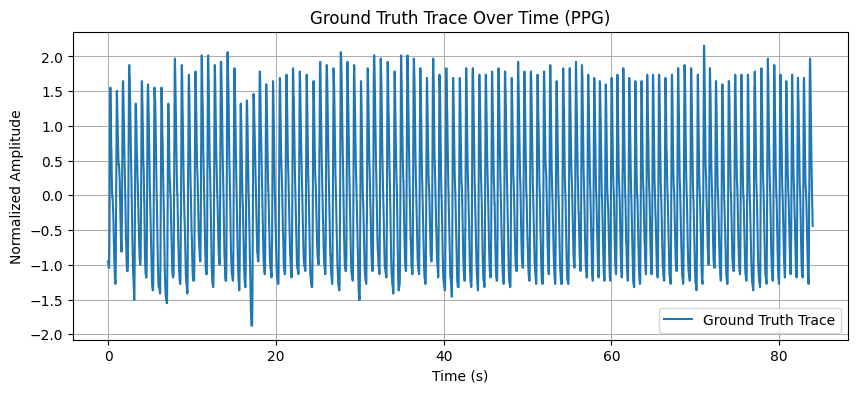

In [4]:
# Plot the ground truth trace
plt.figure(figsize=(10, 4))
plt.plot(gt_time, gt_trace, label='Ground Truth Trace')
plt.title('Ground Truth Trace Over Time (PPG)')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid(True)
plt.show()

## Calculate average heart rate

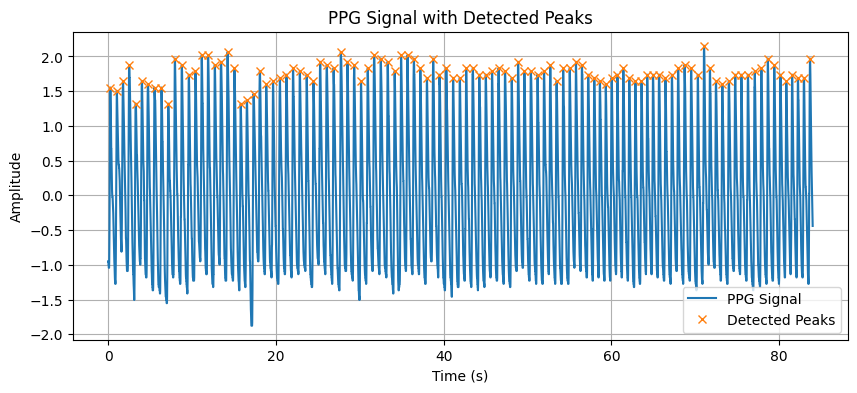

In [28]:
from scipy.signal import find_peaks

# Finds peaks in the PPG signal which corresponds to heartbeats
peaks, _ = find_peaks(gt_trace, distance=fps * 0.5)  # 0.5 means that the peaks detected will be atleast 0.5 seconds apart to avoid detecting noise (0.5 means heart rate ranges from 6-120) # Adjust 'distance' based on expected HR range

plt.figure(figsize=(10, 4))
plt.plot(gt_time, gt_trace, label='PPG Signal')
plt.plot(gt_time[peaks], gt_trace[peaks], "x", label='Detected Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('PPG Signal with Detected Peaks')
plt.legend()
plt.grid(True)
plt.show()

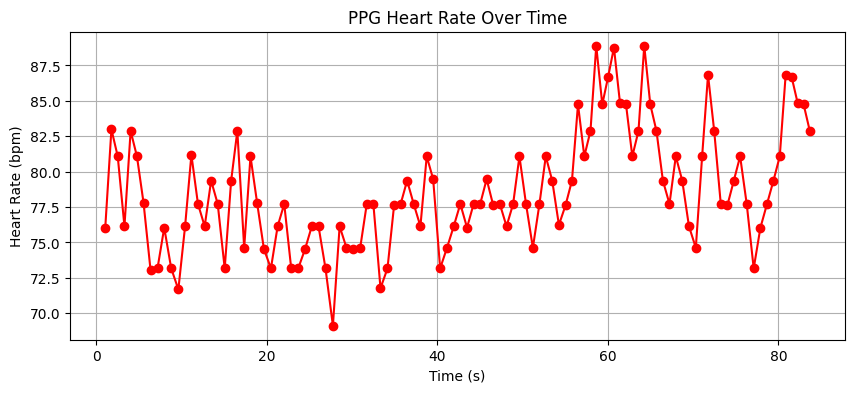

Average Heart Rate from PPG: 78.62 bpm


In [35]:
# Calculate time intervals between successive peaks
peak_intervals = np.diff(gt_time[peaks]) #np.diff() gives the time gap between the consecutive peaks in gt_time[peaks] known as Interbeat Intervals which is the time gap between 2 consecutive heartbeats

# Convert intervals to heart rate (bpm)
heart_rate = 60 / peak_intervals  # bpm #heart rate is calculated by taking the reciprocal of the IBI (which gives bps) and multiplying by 60 (to convert to bpm).

# Time at which each heart rate measurement was taken
# We use the time of the second peak onwards because the first interval defines the first heart rate measurement
heart_rate_times = gt_time[peaks[1:]]

# Plot the heart rate over time
plt.figure(figsize=(10, 4))
plt.plot(heart_rate_times, heart_rate, marker='o', linestyle='-', color='r')
plt.title('PPG Heart Rate Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate (bpm)')
plt.grid(True)
plt.show()

# Calculate the average heart rate
average_heart_rate = np.mean(heart_rate)

# Print the average heart rate
print(f'Average Heart Rate from PPG: {average_heart_rate:.2f} bpm')

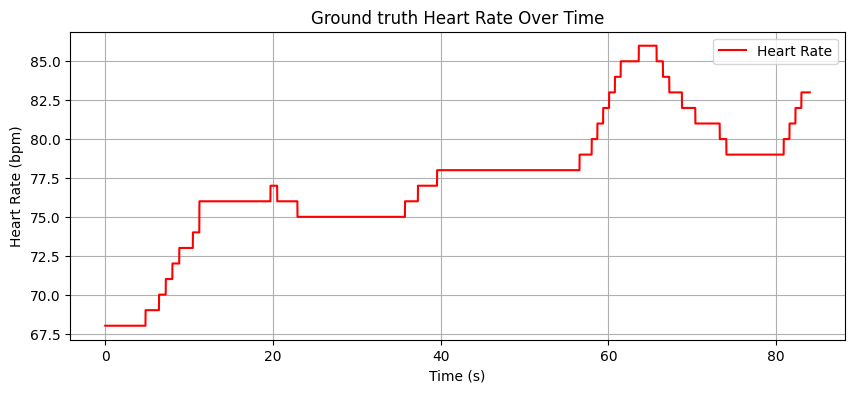

Average Grounf truth Heart Rate: 77.32 bpm


In [8]:
# Plot the ground truth heart rate
plt.figure(figsize=(10, 4))
plt.plot(gt_time, gt_hr, label='Heart Rate', color='red')
plt.title('Ground truth Heart Rate Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate (bpm)')
plt.legend()
plt.grid(True)
plt.show()

avg_heartrate = np.mean(gt_hr)

print(f'Average Ground truth Heart Rate: {avg_heartrate:.2f} bpm')